<a href="https://colab.research.google.com/github/pinholuc/mlops/blob/master/ml_handbook/feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd

df = pd.read_excel('./titanic3.xls')
df_aux = pd.read_excel("./titanic3.xls")
# Droping features that are not useful to our model
df = df.drop(columns = ["name", 
                        "ticket", 
                        "home.dest", 
                        "boat", 
                        "body", 
                        "cabin"])

# Getting rid of string/object features
df = pd.get_dummies(df).drop(columns="sex_male")
df["cabin"] = df_aux.cabin

df_aux = df_aux.drop(columns = ["name", 
                               "ticket", 
                                "home.dest", 
                                "boat", 
                                "body", 
                                "cabin"]).dropna()

X = pd.get_dummies(df_aux).drop(columns=["survived", "sex_male"])

# Labels (y)
y = df_aux.survived

# Gerando novos atributos
agg = df.groupby("cabin").agg("min,max,mean,sum".split(",")).reset_index()
agg.columns = [
    "_".join(c).strip("_")
    for c in agg.columns.values
]
agg_df = df.merge(agg, on="cabin")
display(agg_df)

,pclass,survived,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S,...,embarked_C_mean,embarked_C_sum,embarked_Q_min,embarked_Q_max,embarked_Q_mean,embarked_Q_sum,embarked_S_min,embarked_S_max,embarked_S_mean,embarked_S_sum
0,1,1,29.0000,0,0,211.3375,1,0,0,1,...,0.0,0,0,0,0.0,0,1,1,1.0,2
1,1,1,15.0000,0,1,211.3375,1,0,0,1,...,0.0,0,0,0,0.0,0,1,1,1.0,2
2,1,1,0.9167,1,2,151.5500,0,0,0,1,...,0.0,0,0,0,0.0,0,1,1,1.0,4
3,1,0,2.0000,1,2,151.5500,1,0,0,1,...,0.0,0,0,0,0.0,0,1,1,1.0,4
4,1,0,30.0000,1,2,151.5500,0,0,0,1,...,0.0,0,0,0,0.0,0,1,1,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,3,1,24.0000,0,2,16.7000,1,0,0,1,...,0.0,0,0,0,0.0,0,1,1,1.0,5
291,3,1,4.0000,1,1,16.7000,1,0,0,1,...,0.0,0,0,0,0.0,0,1,1,1.0,5
292,3,0,2.0000,0,1,10.4625,1,0,0,1,...,0.0,0,0,0,0.0,0,1,1,1.0,5
293,3,0,29.0000,1,1,10.4625,1,0,0,1,...,0.0,0,0,0,0.0,0,1,1,1.0,5


In [43]:
"""
Feature selection: atributos irrelevantes podem causar efeito negativo em um modelo.
Atributos correlacionados podem deixar os coeficientes de uma regressao (ou 
a importacia dos atributos em modelos de arvore) instaveis ou dificeis de inter-
pretar.

A maldicao da dimensionalidade eh outra questao a ser considerada. A medida que
voce aumentar o numero de dimensoes de seus dados, eles se tornarao mais esparsos.
Isso pode dificultar a obtencao de um sinal, a menos que voce tenha mais dados.
"""

'\nFeature selection: atributos irrelevantes podem causar efeito negativo em um modelo.\nAtributos correlacionados podem deixar os coeficientes de uma regressao (ou \na importacia dos atributos em modelos de arvore) instaveis ou dificeis de inter-\npretar.\n\nA maldicao da dimensionalidade eh outra questao a ser considerada. A medida que\nvoce aumentar o numero de dimensoes de seus dados, eles se tornarao mais esparsos.\nIsso pode dificultar a obtencao de um sinal, a menos que voce tenha mais dados.\n'

In [44]:
!pip install rfpimp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
# Colunas colineares
import numpy as np 

limit = 0.95
corr = agg_df.corr()
mask = np.triu(np.ones(corr.shape), k=1).astype(bool)

corr_no_diag = corr.where(mask)

coll = [
    c 
    for c in corr_no_diag.columns
    if any(abs(corr_no_diag[c]) > limit)
]
coll

['embarked_S',
 'pclass_min',
 'pclass_max',
 'pclass_mean',
 'sibsp_mean',
 'parch_mean',
 'fare_mean',
 'embarked_C_min',
 'embarked_C_max',
 'embarked_C_mean',
 'embarked_S_min',
 'embarked_S_max',
 'embarked_S_mean']

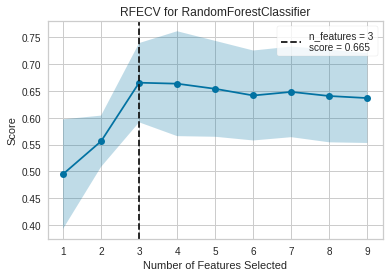

In [47]:
# Eliminacao recursiva de atributos

from yellowbrick.features import RFECV
import matplotlib.pyplot as plt
from sklearn import ensemble

fig, ax = plt.subplots(figsize=(6, 4))

rfe = RFECV(
    ensemble.RandomForestClassifier(
        n_estimators=100
    ),
    cv=5
)

rfe.fit(X, y)
rfe.rfe_estimator_.ranking_
rfe.rfe_estimator_.n_features_
rfe.rfe_estimator_.support_

rfe.poof()
fig.savefig("feature_selection.png", dpi=300)

In [53]:
from sklearn.feature_selection import RFE

model = ensemble.RandomForestClassifier(n_estimators=10)

rfe = RFE(model, n_features_to_select=4)
rfe.fit(X, y)
X.columns[rfe.support_]

Index(['pclass', 'age', 'fare', 'sex_female'], dtype='object')

In [ ]:
# Tambem pode ser realizada analise de PCA para remover atributos irrelevantes